<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment03/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Nama : Sapto Nugroho

##NIU : 565712

Implement one of the segmentation methods and several operation of morphological methods without using library. Comparing the segmentation result with and without applying morphological processing.

Create your notebook with name as "PCD_Assignment03". You need to provide your Google Colab's code link to the text editor in submission form.

### Import

In [38]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

PCD  sample_data
fatal: destination path 'PCD' already exists and is not an empty directory.
PCD  sample_data


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io, img_as_float
import cv2
from collections import deque
import copy

### Fungsi, dan Input citra

In [23]:
def show_img(input):
  # plt.figure(figsize=(10,3))
  plt.imshow(input, cmap='gray')
  plt.title(f"Original {input.shape[0]} x {input.shape[1]}")
  # plt.axis("off")
  plt.show()

def show_img1(img):
  plt.imshow(img, cmap='gray')
  plt.colorbar()
  plt.show()

def show_hist(input):
  img1d = input.ravel()
  sorted = np.sort(img1d)
  bins = np.arange(0, 257)
  fig = plt.figure(figsize =(6, 6))
  plt.hist(sorted, bins)
  plt.title("Histogram")
  plt.show()

def input_img(img_path):
  img0 = cv2.imread(img_path)
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img0 = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
  # img = img_as_float(img)
  img = copy.deepcopy(img0)
  # print(img.shape)
  # print(img)

  return img

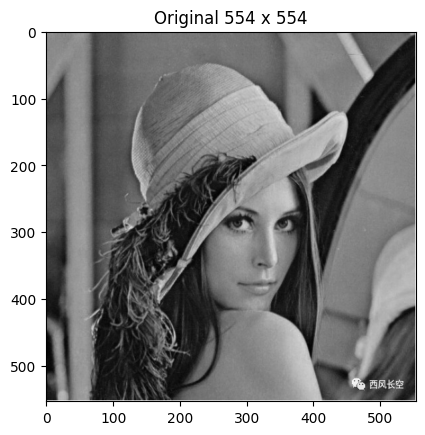

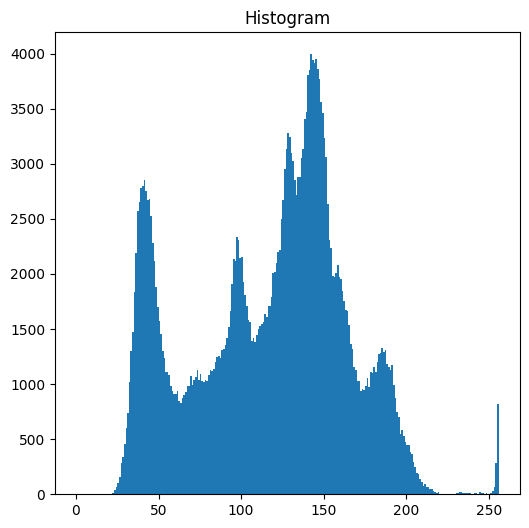

In [6]:
img_path = {
    "woman": '/content/PCD/PCD_Assignment03/images/woman01.jpg',
    "doc": '/content/PCD/PCD_Assignment03/images/script.png',
    "grid": '/content/PCD/PCD_Assignment03/images/grid.jpg',
    "16": '/content/PCD/PCD_Assignment03/images/16x16.jpg',
    "8": '/content/PCD/PCD_Assignment03/images/8x8.jpg',
    "4": '/content/PCD/PCD_Assignment03/images/4x4.jpg'
}

# img_path.extend(['/content/PCD/PCD_Assignment03/images/woman01.jpg','/content/PCD/PCD_Assignment03/images/script.png','/content/PCD/PCD_Assignment03/images/grid.jpg',
#                  '/content/PCD/PCD_Assignment03/images/16x16.jpg','/content/PCD/PCD_Assignment03/images/8x8.jpg','/content/PCD/PCD_Assignment03/images/4x4.jpg'])
# print(img_path)

img = input_img(img_path["woman"])
show_img(img)
show_hist(img)

### **SEGMENTASI**

####  **PIXEL BASED**



##### Basic Global Thresholding

Threshold (T):  159.0


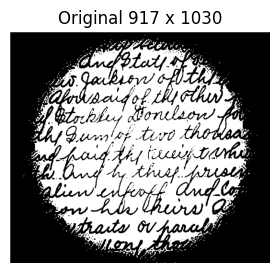

In [ ]:
def global_threshold(input):
  input = input.astype(np.float64)
  output = np.zeros_like(input)
  img1d = input.ravel()
  sorted = np.sort(img1d)
  val, freq = np.unique(img1d, return_counts=True)

  T1 =np.floor(np.mean(img1d))#Nilai Threshold
  T2 = T1
  T3 = 0
  sorted = np.sort(img1d)

  while (T3-T1 != 0):
    first = sorted[sorted <= T2]
    second = sorted[sorted > T2]
    T1 = T2
    # print(first)
    # print(second)
    # print(np.floor(np.mean(first)))
    # print(np.floor(np.mean(second)))

    m1 = np.floor(np.mean(first))
    m2 = np.floor(np.mean(second))
    T3 = (m1+m2)/2
    # print(T1)
    # print(T3)
    # print(T3-T1)
    T2 = T3

  T3 = np.floor(T3)
  print("Threshold (T): ",T3)

  for i in range(input.shape[0]):
    for j in range(input.shape[1]):
      if input[i,j] > T3:
        output[i,j] = 255
      else:
        output[i,j] = 0

  return output

output = global_threshold(img)
show_img(output)

##### Metode Otsu

Threshold (T):  162.0


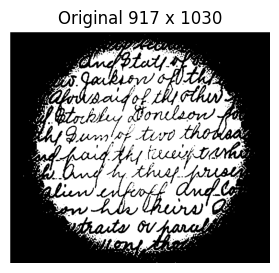

In [ ]:
def otsu(input):
  input = input.astype(np.float64)
  img1d = input.ravel()
  output = np.zeros_like(input)
  sorted = np.sort(img1d)
  val, freq = np.unique(sorted, return_counts=True)
  # print(val)
  # print(freq)

  # val_freq = np.stack((val,freq), axis=1)
  # print(val_freq)

  var_w = np.zeros(len(val))

  for i in range(1,len(val)):

    weight_b = np.sum(freq[0:i])/np.sum(freq)
    mean_b = np.sum(val[0:i]*freq[0:i])/np.sum(freq[0:i])
    var_b = np.sum(((val[0:i]-mean_b)**2)*freq[0:i])/np.sum(freq[0:i])

    weight_f = np.sum(freq[i:])/np.sum(freq)
    mean_f = np.sum(val[i:]*freq[i:])/np.sum(freq[i:])
    var_f = np.sum(((val[i:]-mean_f)**2)*freq[i:])/np.sum(freq[i:])

    var_w[i] = weight_b*var_b + weight_f*var_f

  # print(var_w.shape)
  # print(var_w)

  mask = (var_w != 0) & ~np.isnan(var_w)
  min_idx = np.nanargmin(np.where(mask, var_w, np.nan))
  min_val = var_w[min_idx]
  # print(min_idx, min_val)
  T = val[min_idx]
  print("Threshold (T): ",T)

  for i in range(input.shape[0]):
    for j in range(input.shape[1]):
      if input[i,j] > T:
        output[i,j] = 255
      else:
        output[i,j] = 0

  return output

output = otsu(img)
show_img(output)

##### Adaptive Thresholding (Moving Average)

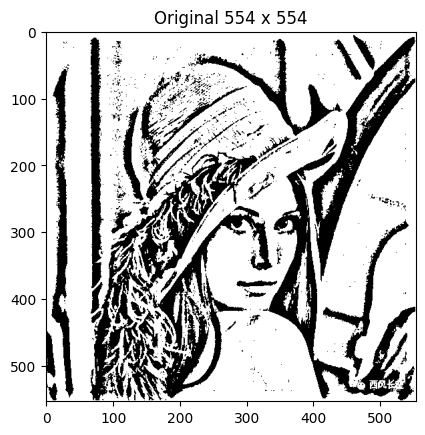

In [9]:
def moving_avg(input,n,c):

  output = np.zeros_like(input)
  input = input.astype(np.float64)
  kernel = np.ones((n, n), dtype=np.float64) / (n * n)
  ksize = kernel.shape[0]
  pad = ksize // 2
  # h, w = input.shape
  # kh, kw = kernel.shape
  # pad_h, pad_w = kh // 2, kw // 2

  # Padding citra
  padded = np.pad(input, pad, mode='constant')
  # padded = np.pad(input, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      region = padded[i:i+ksize, j:j+ksize]
      T = np.sum(region * kernel)*c
      if input[i,j] > T:
        output[i,j] = 255
      else:
        output[i,j] = 0

  return output

out = moving_avg(img,31,0.95)
show_img(out)

###### Split image

Total blocks: 16


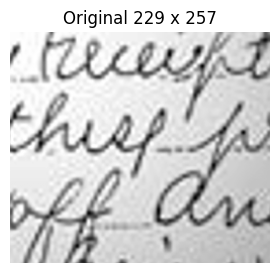

In [ ]:
def split_img_blocks(img, rows, cols):
    """Split image into (rows × cols) sub-blocks without cropping."""
    h, w = img.shape[:2]

    # Compute split indices (evenly spaced)
    row_splits = np.linspace(0, h, rows + 1, dtype=int)
    col_splits = np.linspace(0, w, cols + 1, dtype=int)

    # Slice using NumPy indexing
    blocks = [
        img[row_splits[i]:row_splits[i+1], col_splits[j]:col_splits[j+1]]
        for i in range(rows)
        for j in range(cols)
    ]
    return blocks

rows, cols = 4, 4
block = split_img_blocks(img, rows, cols)

print("Total blocks:", len(block))
# print(block[0])
# print("Each block shape:")
# for i, b in enumerate(block):
#     print(f" Block {i}: {b.shape}")

show_img(block[10])

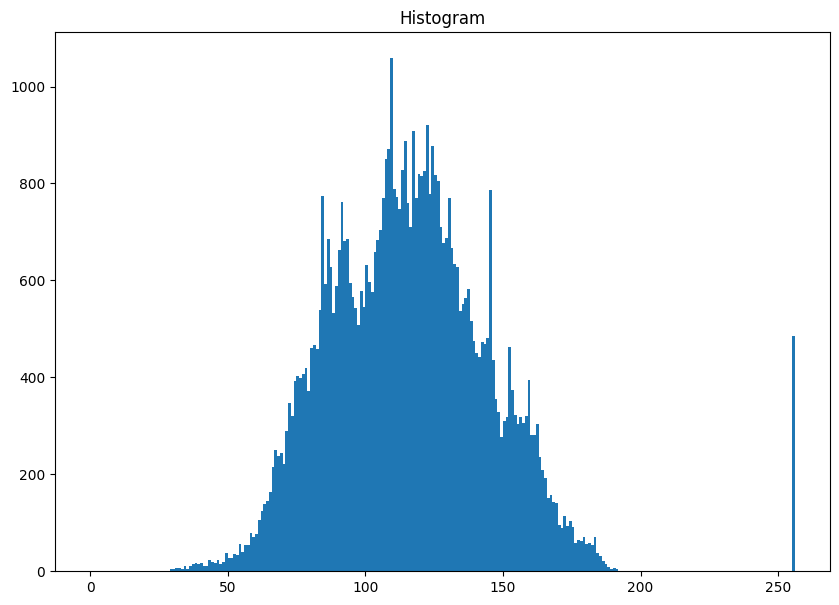

In [ ]:
block1d = []
val = []
freq = []
for i in range(len(block)):
  block1d.append(block[i].ravel())

for i in range(len(block1d)):
  nilai, frekuensi = np.unique(block1d[i], return_counts=True)
  val.append(nilai)
  freq.append(frekuensi)

# print(val[0])

show_hist(block1d[0])

Threshold (T):  182.0


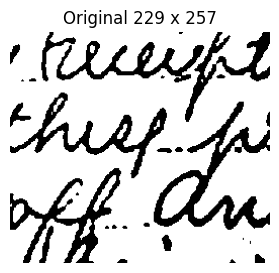

In [ ]:
output1 = otsu(block[10])
show_img(output1)

##### Probability Thresholding
Algoritma

*   Data = citra-citra objek yang ingin dideteksi, contoh: asap, api, air, dll
*   Training data, hitung nilai mean dan variance lalu buat distribusinya
*   Distribusi sebagai nilai acuan untuk piksel pada citra baru
*   Gunakan fungsi Gaussian untuk menentukan piksel termasuk objek atau bukan





In [ ]:
# def prob_threshold():
#   Algorithm Probability Thresholding

#   Input:
#       Image RGB berukuran M × N
#       μR, μG, μB     ← rata-rata kanal warna dari data pelatihan
#       σR, σG, σB     ← standar deviasi kanal warna dari data pelatihan
#       T              ← nilai ambang probabilitas

#   Output:
#       BinaryMask[M][N]

#   Begin
#       For i ← 1 to M do
#           For j ← 1 to N do
#               (R, G, B) ← nilai piksel pada (i, j)

#               // Hitung probabilitas Gaussian untuk tiap kanal
#               PR ← (1 / (√(2π) * σR)) * exp( -((R - μR)^2) / (2 * σR^2) )
#               PG ← (1 / (√(2π) * σG)) * exp( -((G - μG)^2) / (2 * σG^2) )
#               PB ← (1 / (√(2π) * σB)) * exp( -((B - μB)^2) / (2 * σB^2) )

#               // Asumsikan ketiga kanal independen
#               Ptotal ← PR * PG * PB

#               // Bandingkan dengan nilai ambang probabilitas
#               If Ptotal > T then
#                   BinaryMask[i][j] ← 1   // piksel termasuk objek
#               Else
#                   BinaryMask[i][j] ← 0   // piksel bukan objek
#       Return BinaryMask
#   End

#   return output

####  **REGION BASED**

##### Region Growing

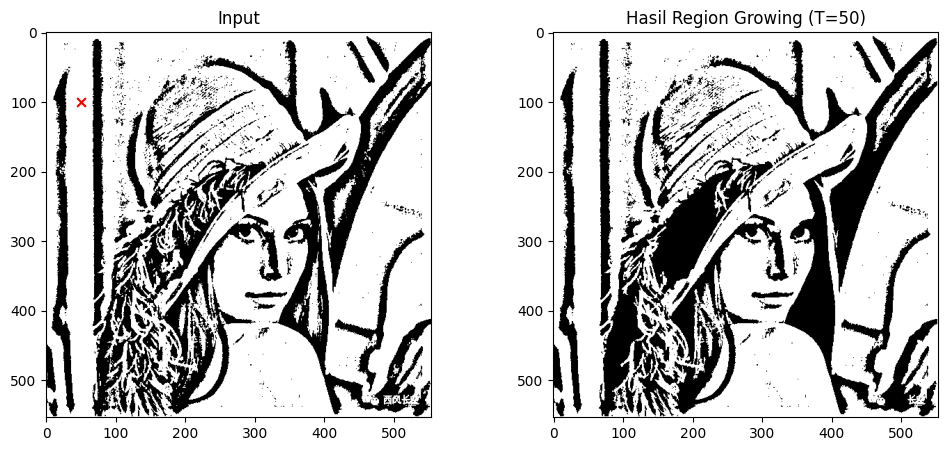

In [35]:
def region_growing_multi(input, seed_points, T):

  # gray = cv2.cvtColor(input, cv2.COLOR_BGR2GRAY)
  gray = input

  def region_growing(input, seed, T):
    h, w = input.shape
    region = np.zeros((h, w), dtype=bool)
    visited = np.zeros((h, w), dtype=bool)

    neighbors = [(-1,-1), (-1,0), (-1,1),
                  (0,-1),          (0,1),
                  (1,-1),  (1,0),  (1,1)]

    q = deque([seed])
    seed_val = int(input[seed])
    visited[seed] = True

    while q:
      y, x = q.popleft()
      region[y, x] = True

      for dy, dx in neighbors:
        ny, nx = y + dy, x + dx
        if 0 <= ny < h and 0 <= nx < w and not visited[ny, nx]:
          diff = abs(int(input[ny, nx]) - seed_val)
          if diff <= T:
            q.append((ny, nx))
          visited[ny, nx] = True

    return (region.astype(np.uint8)) * 255

  #Jalankan untuk semua seed dan gabungkan hasil
  h, w = gray.shape
  final_mask = np.zeros((h, w), dtype=np.uint8)

  for i, seed in enumerate(seed_points, start=1):
    # print(f"Proses seed ke-{i}: {seed}")
    mask = region_growing(gray, seed, T)
    final_mask = cv2.bitwise_or(final_mask, mask)

  #Visualisasi hasil
  plt.figure(figsize=(12,5))

  plt.subplot(1,2,1)
  plt.title("Input")
  plt.imshow(gray, cmap='gray')
  for s in seed_points:
      plt.scatter(s[1], s[0], c='red', s=40, marker='x')

  plt.subplot(1,2,2)
  plt.title(f"Hasil Region Growing (T={T})")
  plt.imshow(final_mask, cmap='gray')
  plt.show()

  return final_mask

hasil = region_growing_multi(out, seed_points=[(100,50)], T=50)

##### Watershed / Flood fill

##### Clustering

#### **FEATURE BASED / DETECTION**

##### Sliding Window

### **MORFOLOGI**

#### **Erosi**

#### **Dilasi**

#### **Opening**

#### **Closing**

### JUNK

In [ ]:
# imag = np.array([[0,0,0,0,0,0,0,0],
#                  [0,0,0,5,5,0,0,0],
#                  [0,0,5,5,5,5,0,0],
#                  [0,0,5,5,5,5,5,0],
#                  [0,5,5,5,5,5,0,0],
#                  [0,0,5,5,5,5,0,0],
#                  [0,0,0,5,5,0,0,0],
#                  [0,0,0,0,0,0,0,0]])

imag = np.array([[0,0,0,0,0,0,0,0],
                 [0,0,0,5,3,0,0,0],
                 [0,0,5,1,5,5,0,0],
                 [0,0,4,5,4,1,3,0],
                 [0,5,5,4,5,5,0,0],
                 [0,0,5,3,5,4,0,0],
                 [0,0,0,2,2,0,0,0],
                 [0,0,0,0,0,0,0,0]])
show_img(imag)

#MASK
mask = np.zeros_like(imag)

#SEED
# seed = [np.random.randint(imag.shape[0]),np.random.randint(imag.shape[1])]
# seed = np.array([[3,3],[4,4],[5,5]])
seed = np.array([[3,3]])
# print(seed)
# seed = np.vstack([seed,[1,5]])
# print(seed)

#8-NEIGHBORS
neighbors = np.array([[0,1],[0,-1],[1,0],[-1,0],
                      [1,1],[1,-1],[-1,1],[-1,-1]])
# print(neighbors)

#Masukkan koordinat dalam mask
for x in seed:
  # print(x)
  # print(x[1])
  # print(mask[x[0],x[1]])
  mask[x[0],x[1]] = 1

print(mask)
# show_img(mask)

#Cek neighbors memenuhi threshold?
T = 1
for x in seed:
  print('x : ', x,'====================================')
  for y in neighbors:
    z = x+y
    # print(z)
    # print(z[1])

    #Masukkan koordinat neighbors yang memenuhi dalam array seed
    if imag[z[0],z[1]] >= imag[x[0],x[1]] - T and imag[z[0],z[1]] <= imag[x[0],x[1]] + T:

      if mask[z[0],z[1]] == 0:
        mask[z[0],z[1]] = 1
      # if not np.any(seed == z):
        seed = np.vstack([seed,[z[0],z[1]]])

      print(seed)
  # print(seed[0])

 #Delete koordinat acuan yang sudah digunakan dari array seed
  seed = seed[1:]
  print(seed)

print(mask)
show_img(mask)

for i in range(imag.shape[0]):
  for j in range(imag.shape[1]):
    if imag[i,j] >= T:
      mask[i,j] = 0
    else:
      mask[i,j] = 1
# show_img(mask)


In [ ]:

def reg_grow(input,seed,T):
  #INPUT
  input = input.astype(np.int16)

  # MASK kosong
  mask = np.zeros_like(input)

  # SEED awal
  seed = np.array([seed])   # (row, col)
  T = T                       # threshold perbedaan intensitas

  # 8-NEIGHBORS
  neighbors = np.array([[-1,-1],[-1,0],[-1,1],
                        [0,-1],        [0,1],
                        [1,-1],[1,0],[1,1]])

  # Tandai seed awal di mask
  mask[seed[0,0], seed[0,1]] = 1

  # Mulai region growing
  while len(seed) > 0:

    # print('====================================')
    x = seed[0]     # ambil seed pertama
    # print('seed digunakan:', x)
    seed = seed[1:] # hapus seed pertama
    # print('neighbors dari',x,'===============')

    for y in neighbors:
      z = x + y    # koordinat tetangga
      k, b = z
      # print(k,b)

      # Cek batas citra
      if k < 0 or k >= input.shape[0] or b < 0 or b >= input.shape[1]:
        # print('melewati batas citra')
        continue

      #Cek sudah masuk list seed belum?
      if mask[k, b] == 0:

        # Cek kondisi threshold
        if abs(input[k, b] - input[x[0], x[1]]) <= T:
          # print('masuk')
          mask[k, b] = 1
          seed = np.vstack([seed, [k, b]])

        else:
          # print('tidak memenuhi')
          pass

      else:
        # print("sudah masuk")
        pass

    # print('list seed===========================')
    # print(seed)
    # print('==================================')
  return mask

# show_img1(out)
seed=[100,55]
out1 = reg_grow(out,seed,2)
# show_img1(out1)

#Tampilkan hasil
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Citra Asli")
plt.imshow(out, cmap='gray')
plt.scatter(100,50, c='red', s=40, marker='x')

plt.subplot(1,2,2)
plt.title(f"Hasil Region Growing")
plt.imshow(out1, cmap='gray')
plt.show()

